In [1]:
# Environment
# Python 3.8.10 64-bit
# Oracle JDK required.

Install packages and libraries

In [3]:
#%pip install python-weka-wrapper3
#%pip install plotly

In [1]:
# Install python packages typically used with weka. Add / Remove items as needed.

import os
import glob
import tempfile
import itertools
import traceback
import numpy as np
import pandas as pd
import weka.core.jvm as jvm
import matplotlib.pyplot as plt
import weka.plot.classifiers as plot_cls
import plotly.graph_objects as go
import weka.plot.graph as graph
import weka.plot.graph as plot_graph
import weka.core.typeconv as typeconv
import weka.core.converters as converters
import plotly.graph_objects as go
import weka.plot.classifiers as plcls

from weka.filters import Filter
from weka.core.classes import from_commandline
from weka.core.classes import to_commandline
from weka.classifiers import Evaluation
from weka.core.classes import Random
from weka.filters import Filter
from weka.classifiers import Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random, from_commandline
from weka.classifiers import Classifier, SingleClassifierEnhancer, MultipleClassifiersCombiner, FilteredClassifier
from weka.classifiers import PredictionOutput, Kernel, KernelClassifier
from weka.experiments import SimpleCrossValidationExperiment, SimpleRandomSplitExperiment, Tester, ResultMatrix

Load data and create combined csv file

Start Java VM for algorithm library and load data

In [3]:
import weka.core.jvm as jvm
jvm.start(packages=True,max_heap_size="16g")

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


In [4]:
# Load csv file

from weka.core.converters import Loader

csv_loader = Loader(classname="weka.core.converters.CSVLoader", options=["-N","49"])
csv_data = csv_loader.load_file("wustl_iiot_2021.csv")
csv_data.class_is_last()

csv_remove = Filter(classname="weka.filters.unsupervised.attribute.Remove", options=["-R", "1,2,3,4,38,39,48"])
csv_remove.inputformat(csv_data)
dataset = csv_remove.filter(csv_data)


#csv_nominal = Filter(classname="weka.filters.unsupervised.attribute.NumericToNominal", options=["-R", "last"])
#csv_nominal.inputformat(step_dataset)
#dataset = csv_nominal.filter(csv_nominal)


In [5]:
# create plot function

def plot_confusion_matrix(cm, title):

  plt.gcf().clear()
  fig = plt.figure(1)
  classes = ['Class A', 'Class B']
  plt.imshow(cm, interpolation='none', cmap=plt.cm.Blues, alpha=0.3)
  plt.title(title)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  fmt = 'd'
  thresh = 155
  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="black")
  plt.imshow
  plt.tight_layout()
  plt.ylabel('Actual')
  plt.xlabel('Predicted') 
  
  image = fig 
  display(image)
  plt.close(fig)

Decision Tree

In [15]:
# Build and run decision tree model

DT = Classifier(classname="weka.classifiers.trees.J48", options=["-C", "0.3"])
DT.build_classifier(dataset)

DT_evl = Evaluation(dataset)
DT_evl.evaluate_train_test_split(DT, dataset, 80)

print(DT_evl.summary())
print(DT_evl.class_details())


Correctly Classified Instances      238885               99.9967 %
Incorrectly Classified Instances         8                0.0033 %
Kappa statistic                          0.9998
Mean absolute error                      0     
Root mean squared error                  0.0055
Relative absolute error                  0.0336 %
Root relative squared error              2.133  %
Total Number of Instances           238893     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     0
                 1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     1
Weighted Avg.    1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     



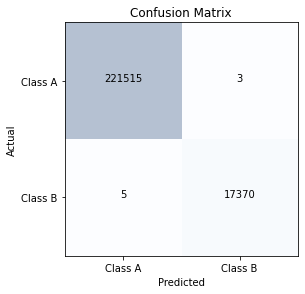

In [18]:
# Create array and print Confusion matrix graphic

evl = DT_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")


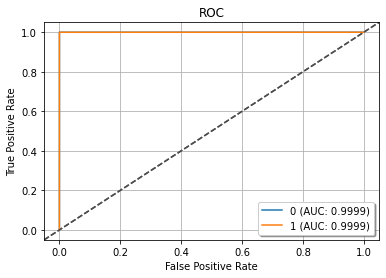

In [19]:
# Display ROC Curve

plcls.plot_roc(DT_evl, class_index=[0, 1], wait=True)

AdaBoost Decision Stump

In [20]:
# Build and run Decision Stump model with adaptive boosting ensemble algorithm 

B_DS_cmdline = 'weka.classifiers.meta.AdaBoostM1 -P 100 -S 1 -I 10 -W weka.classifiers.trees.DecisionStump'
B_DS_cls = from_commandline(B_DS_cmdline, classname="weka.classifiers.Classifier")
B_DS_cls.build_classifier(dataset)

B_DS_evl = Evaluation(dataset)
B_DS_evl.evaluate_train_test_split(B_DS_cls, dataset, 80)

print(B_DS_evl.summary())
print(B_DS_evl.class_details())


Correctly Classified Instances      238751               99.9406 %
Incorrectly Classified Instances       142                0.0594 %
Kappa statistic                          0.9956
Mean absolute error                      0.0016
Root mean squared error                  0.0231
Relative absolute error                  1.1629 %
Root relative squared error              8.8983 %
Total Number of Instances           238893     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.008    0.999      1.000    1.000      0.996    1.000     1.000     0
                 0.992    0.000    1.000      0.992    0.996      0.996    1.000     1.000     1
Weighted Avg.    0.999    0.007    0.999      0.999    0.999      0.996    1.000     1.000     



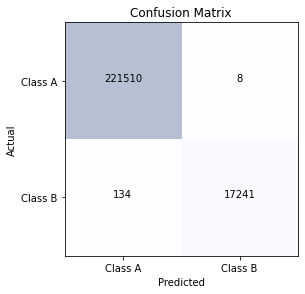

In [21]:
# Create array and print Confusion matrix graphic

evl = B_DS_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

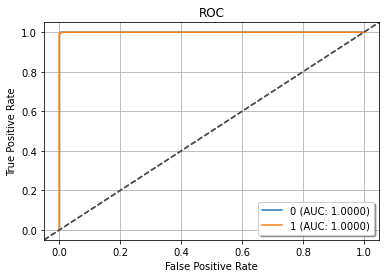

In [22]:
# Display ROC Curve

plcls.plot_roc(B_DS_evl, class_index=[0, 1], wait=True)

Naive Bayes

In [23]:
# Build and run Naive Bayes model

NB_cls = Classifier(classname="weka.classifiers.bayes.NaiveBayes")
NB_cls.build_classifier(dataset)

NB_evl = Evaluation(dataset)
NB_evl.evaluate_train_test_split(NB_cls, dataset, 80)

print(NB_evl.summary())
print(NB_evl.class_details())


Correctly Classified Instances      233108               97.5784 %
Incorrectly Classified Instances      5785                2.4216 %
Kappa statistic                          0.8441
Mean absolute error                      0.0242
Root mean squared error                  0.1553
Relative absolute error                 17.9177 %
Root relative squared error             59.8151 %
Total Number of Instances           238893     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.974    0.002    1.000      0.974    0.987      0.854    0.988     0.999     0
                 0.998    0.026    0.751      0.998    0.857      0.854    0.988     0.766     1
Weighted Avg.    0.976    0.004    0.982      0.976    0.977      0.854    0.988     0.982     



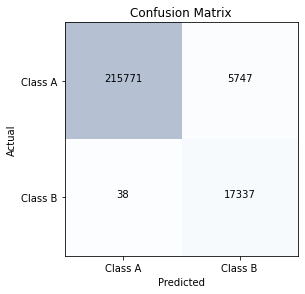

In [24]:
# Create array and print Confusion matrix graphic

evl = NB_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

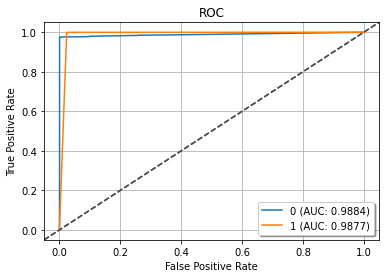

In [25]:
# Display ROC Curve

plcls.plot_roc(NB_evl, class_index=[0, 1], wait=True)

MLP Neural Network

In [26]:
# Build and run MLP model

MLP_cls = Classifier(classname="weka.classifiers.functions.MLPClassifier")
MLP_cls.build_classifier(dataset)

MLP_evl = Evaluation(dataset)
MLP_evl.evaluate_train_test_split(MLP_cls, dataset, 80)

print(MLP_evl.summary())
print(MLP_evl.class_details())


Correctly Classified Instances      237077               99.2398 %
Incorrectly Classified Instances      1816                0.7602 %
Kappa statistic                          0.9452
Mean absolute error                      0.0138
Root mean squared error                  0.0846
Relative absolute error                 10.2214 %
Root relative squared error             32.5676 %
Total Number of Instances           238893     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.994    0.022    0.998      0.994    0.996      0.946    0.994     0.999     0
                 0.978    0.006    0.922      0.978    0.949      0.946    0.993     0.924     1
Weighted Avg.    0.992    0.021    0.993      0.992    0.993      0.946    0.994     0.994     



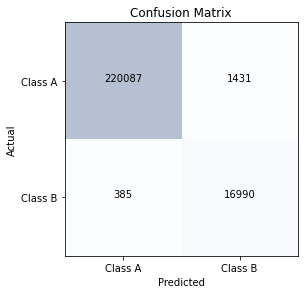

In [27]:
# Create array and print Confusion matrix graphic

evl = MLP_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

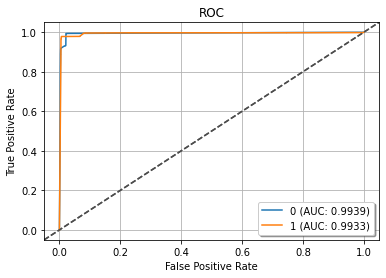

In [28]:
# Display ROC Curve

plcls.plot_roc(MLP_evl, class_index=[0, 1], wait=True)

Stochastic Gradient Descent

In [29]:
# Build and run SGD model

SGD = Classifier(classname="weka.classifiers.functions.SGD")
SGD.build_classifier(dataset)

SGD_evl = Evaluation(dataset)
SGD_evl.evaluate_train_test_split(SGD, dataset, 80)

print(SGD_evl.summary())
print(SGD_evl.class_details())


Correctly Classified Instances      238486               99.8296 %
Incorrectly Classified Instances       407                0.1704 %
Kappa statistic                          0.9873
Mean absolute error                      0.0017
Root mean squared error                  0.0413
Relative absolute error                  1.2621 %
Root relative squared error             15.894  %
Total Number of Instances           238893     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.020    0.998      1.000    0.999      0.987    0.990     0.998     0
                 0.980    0.000    0.996      0.980    0.988      0.987    0.990     0.978     1
Weighted Avg.    0.998    0.018    0.998      0.998    0.998      0.987    0.990     0.997     



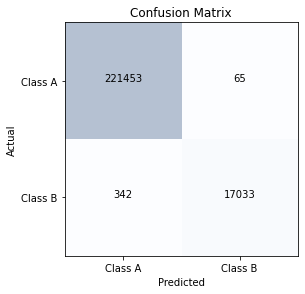

In [30]:
# Create array and print Confusion matrix graphic

evl = SGD_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

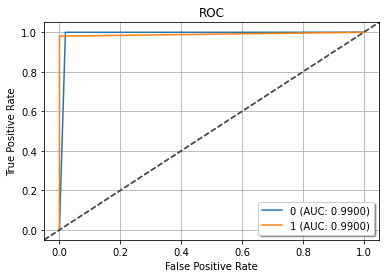

In [31]:
# Display ROC Curve

plcls.plot_roc(SGD_evl, class_index=[0, 1], wait=True)

Voting Feature Intervals

In [6]:
# Build and run voting feature interval model

VFI = Classifier(classname="weka.classifiers.misc.VFI")
VFI.build_classifier(dataset)

VFI_evl = Evaluation(dataset)
VFI_evl.evaluate_train_test_split(VFI, dataset, 80)

print(VFI_evl.summary())
print(VFI_evl.class_details())


Correctly Classified Instances      224289               93.8868 %
Incorrectly Classified Instances     14604                6.1132 %
Kappa statistic                          0.2829
Mean absolute error                      0.353 
Root mean squared error                  0.3712
Relative absolute error                261.4851 %
Root relative squared error            142.9236 %
Total Number of Instances           238893     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.998    0.820    0.940      0.998    0.968      0.386    0.996     1.000     0
                 0.180    0.002    0.896      0.180    0.300      0.386    0.996     0.921     1
Weighted Avg.    0.939    0.760    0.936      0.939    0.919      0.386    0.996     0.994     



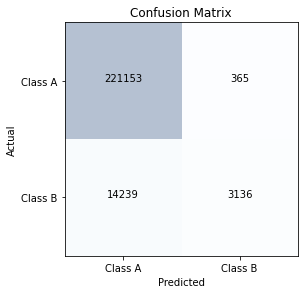

In [7]:
# Create array and print Confusion matrix graphic

evl = VFI_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

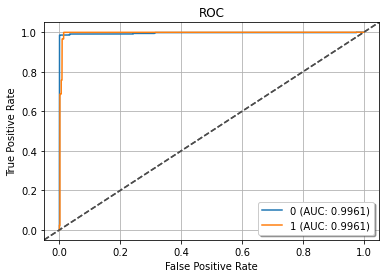

In [9]:
# Display ROC Curve

plcls.plot_roc(VFI_evl, class_index=[0, 1], wait=True)

Stop Java VM

In [34]:
# Stop JVM. May need to restart compute cluster or jupyter kernal if jvm restart is required.

jvm.stop()